In [1]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.signal import butter, lfilter, freqz
from sklearn.decomposition import PCA, FastICA
from meegkit import dss
import pandas as pd

In [2]:
folderPath = os.path.join(os.getcwd(), 'SSVEP_BCI_Dataset')

In [3]:
matFiles = [f for f in os.listdir(folderPath) if f.endswith('.mat')]
matData = scipy.io.loadmat(os.path.join(folderPath,matFiles[1]))
# for matFile in matFiles:
#     matData = scipy.io.loadmat(os.path.join(folderPath,matFile))
    # print(os.path.join(folderPath,matFile),'->',matData['data'].shape)

In [7]:
colName = ['Character', 'Frequency(Hz)', 'Phase（pi)']
characters = ['1','2','3','4','5','6','7','8','9','0','*','#']
FreqHz = [9.25,11.25,13.25,9.75,11.75,13.75,10.25,12.25,14.25,10.75,12.75,14.75]
PhasePi = [0,0,0,0.5,0.5,0.5,1,1,1,1.5,1.5,1.5]
simInfo = pd.DataFrame()
simInfo['Character'] = characters
simInfo['Frequency(Hz)'] = FreqHz
simInfo['Phase（pi)'] = PhasePi
simInfo

,Character,Frequency(Hz),Phase（pi)
0,1,9.25,0.0
1,2,11.25,0.0
2,3,13.25,0.0
3,4,9.75,0.5
4,5,11.75,0.5
5,6,13.75,0.5
6,7,10.25,1.0
7,8,12.25,1.0
8,9,14.25,1.0
9,0,10.75,1.5


In [9]:
channelInd = ['POz', 'PO3', 'PO4', 'PO5', 'PO6', 'Oz', 'O1', 'O2']

In [15]:
sampFreq = 250
timeRange = np.arange(0,2.84,1/sampFreq)
len(timeRange)

710

In [45]:
data = matData['data']
name = ['Time']+channelInd
electrodeIndex = 0
blockIndex = 0
targetIndex = 3
dataMat = [timeRange]
numbChannelIndex = 8
for chnInd in range(numbChannelIndex):
    dataMat.append(data[chnInd,:,electrodeIndex,blockIndex,targetIndex])
df = pd.DataFrame(dataMat)
df = df.transpose()
df.columns = name
df = df.set_index('Time')
df.head()

,POz,PO3,PO4,PO5,PO6,Oz,O1,O2
Time,,,,,,,,
0.000,-59719.476683,-24293.036717,-28439.016845,-20664.052407,-25833.563556,-14740.125223,-27372.257553,-24074.481373
0.004,-61462.018577,-23994.998574,-28706.611914,-20317.332167,-25503.830642,-14392.332100,-27093.754834,-23731.024488
0.008,-60969.564972,-23817.972768,-28077.723269,-20242.364421,-25406.734670,-14321.834703,-26971.043764,-23643.137434
0.012,-58599.386132,-23986.594319,-27224.065496,-20551.489028,-25643.886664,-14630.601682,-27148.248383,-23926.021095
0.016,-57866.874806,-24291.114467,-27478.696554,-20833.880951,-25932.760592,-14898.196751,-27415.530528,-24194.912564


In [17]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [157]:
# Sample rate and desired cutoff frequencies (in Hz).
lowcut = 8.0
highcut = 16.0

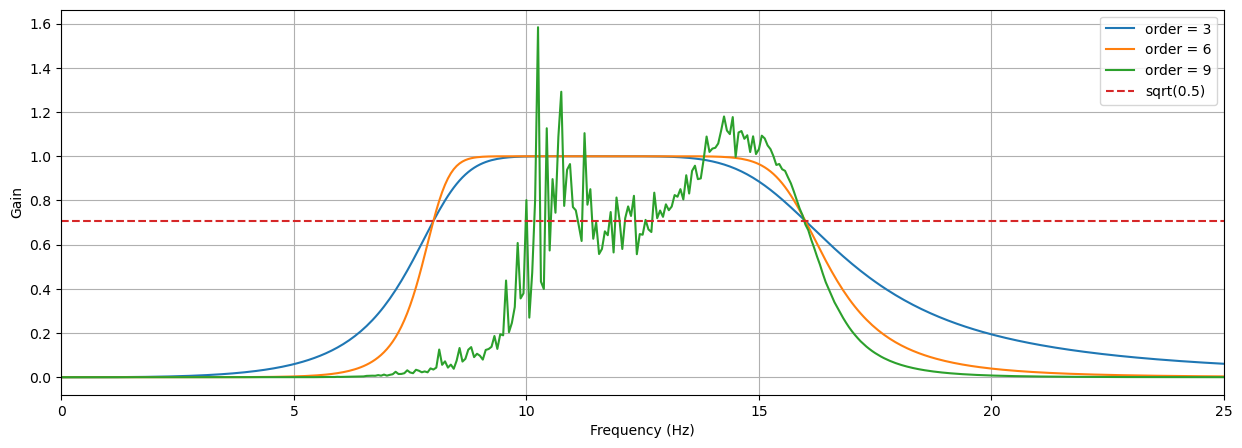

In [159]:
# Plot the frequency response for a few different orders.
plt.figure(figsize=(15,5))
plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, sampFreq, order=order)
    w, h = freqz(b, a, fs=sampFreq, worN=2000)
    plt.plot(w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * sampFreq], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.xlim(0,25)
plt.legend(loc='best')

In [161]:
fOz = butter_bandpass_filter(df['Oz'].values, lowcut, highcut, sampFreq, order=6)

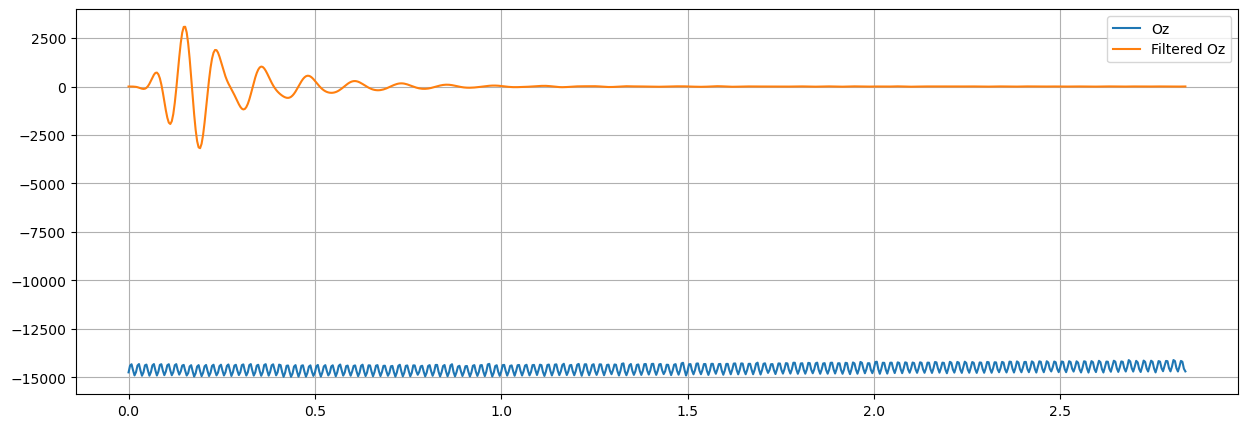

In [163]:
plt.figure(figsize=(15,5))
plt.plot(df.index,df['Oz'].values,label='Oz')
plt.plot(df.index,fOz,label='Filtered Oz')
plt.legend()
plt.grid()
plt.show()

In [165]:
def computeFFT(eeg_data, sampling_rate=250,absVal=True):
    # Length of the signal
    N = len(eeg_data)

    # Compute the FFT
    fft_result = np.fft.fft(eeg_data)

    # Compute the corresponding frequencies
    freqs = np.fft.fftfreq(N, 1/sampling_rate)

    # Get the magnitude of the FFT (only the positive half of the spectrum)
    if absVal:
        fft_magnitude = np.abs(fft_result)[:N//2]
    else:
        fft_magnitude = fft_result[:N//2]
    freqs = freqs[:N//2]
    return freqs, fft_magnitude

In [167]:
Freq,Mag = computeFFT(df['Oz'].values)
_,MagFilter = computeFFT(fOz)

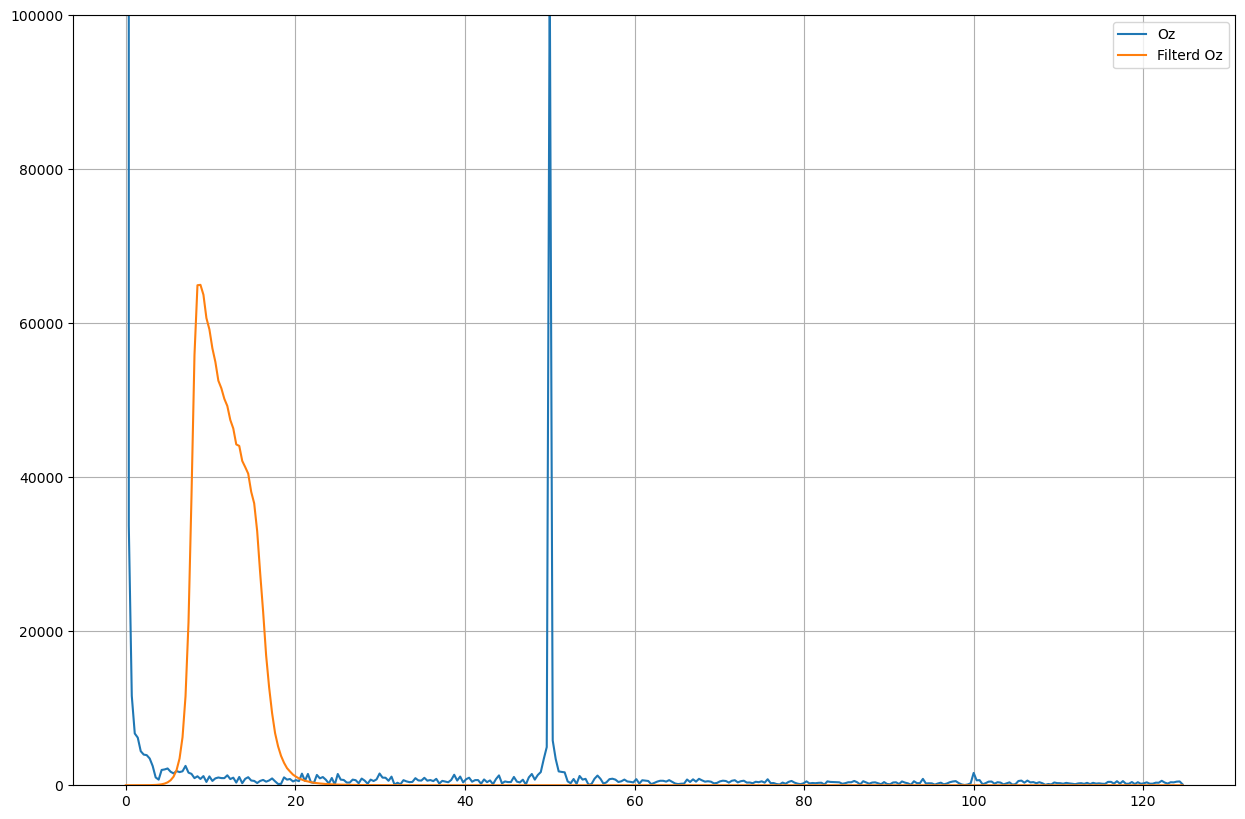

In [169]:
plt.figure(figsize=(15,10))
plt.plot(Freq,Mag,label='Oz')
plt.plot(Freq,MagFilter,label='Filterd Oz')
plt.grid()
# plt.xlim(0,30)
plt.ylim(0,100000)
plt.legend()
plt.show()

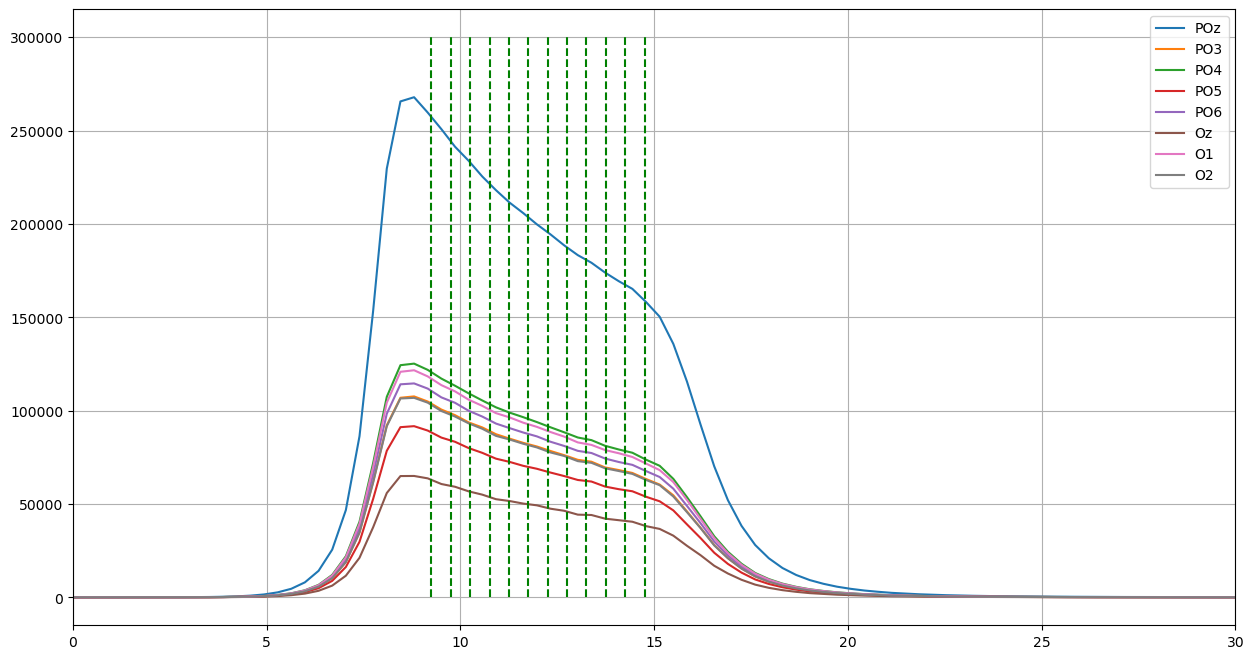

In [171]:
plt.figure(figsize=(15,8))
for ii in channelInd:
    tempSig = butter_bandpass_filter(df[ii].values, lowcut, highcut, sampFreq, order=6)
    Freq,Mag = computeFFT(tempSig)
    plt.plot(Freq,Mag,label=ii)
plt.grid()
plt.xlim(0,30)
plt.vlines(x=FreqHz, ymin=0, ymax= 300000, colors='g', ls='--')
# plt.ylim(0,100000)
plt.legend()
plt.show()